### IPython Notebook Setup

This commands are used needed for plots to appear in the notebook.

In [1]:
%matplotlib inline

# Estimating the Parameters of a GJR-GARCH Model

This example will highlight the steps needed to estimate the parameters of a GJR-GARCH(1,1,1) model with a constant mean. The volatility dynamics in a GJR-GARCH model are given by 
$$\sigma_{t}^{2}=\omega+\sum_{i=1}^{p}\alpha_{i}\epsilon_{t-i}^{2}+\sum_{j=1}^{o}\gamma_{j}r_{t-j}^{2}I_{\left[\epsilon_{t-j}<0\right]}+\sum_{k=1}^{q}\beta_{k}\sigma_{t-k}^{2}.$$

Returns are assumed to be conditionally normal, $r_{t}|\mathcal{F}_{t-1}\sim N\left(\mu,\sigma_{t}^{2}\right)$, $\epsilon_{t}=r_{t}-\mu$ and parameters are estimated by maximum likelihood. To estimate the parameters, it is necessary to:

1. Produce some starting values
2. Estimate the parameters using (quasi-) maximum likelihood
3. Compute standard errors using a “sandwich” covariance estimator (also known as the [BollerslevWooldridge::1992] covariance estimator)

The first task is to write the log-likelihood which can be used in an optimizer. The log-likelihood function will compute the volatility recursion and the log-likelihood. It will also, optionally, return the $T$ by 1 vector of individual log-likelihoods which are useful when approximating the scores.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import size, log, pi, sum, array, zeros, diag, mat, asarray, sqrt, \
    copy
from numpy.linalg import inv
from scipy.optimize import fmin_slsqp

The conditional log-likelihood of a normal random variable is

$$\ln f\left(r_{t}|\mu,\sigma_{t}^{2}\right)=-\frac{1}{2}\left(\ln2\pi+\ln\sigma_{t}^{2}+\frac{\left(r_{t}-\mu\right)^{2}}{\sigma_{t}^{2}}\right),$$

which is negated in the code since the optimizers all minimize.

In [3]:
def gjr_garch_likelihood(parameters, data, sigma2, out=None):
    ''' Returns negative log-likelihood for GJR-GARCH(1,1,1) model.'''
    mu = parameters[0]
    omega = parameters[1]
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]
    
    T = size(data,0)
    eps = data - mu
    # Data and sigma2 are T by 1 vectors
    for t in range(1,T):
        sigma2[t] = (omega + alpha * eps[t-1]**2 
                     + gamma * eps[t-1]**2 * (eps[t-1]<0) + beta * sigma2[t-1])
    
    logliks = 0.5*(log(2*pi) + log(sigma2) + eps**2/sigma2)
    loglik = sum(logliks)
    
    if out is None:
        return loglik
    else:
        return loglik, logliks, copy(sigma2)

The keyword argument `out` has a default value of `None`, and is used to determine whether to return 1 output or 3. This is common practice since the optimizer requires a single output -- the log-likelihood function value, but it is also useful to be able to output other useful quantities, such as $\left\{ \sigma_{t}^{2}\right\}$.

The optimization is constrained so that $\alpha+\gamma/2+\beta\leq 1$, and the constraint is provided in a separate function.

In [4]:
def gjr_constraint(parameters, data, sigma2, out=None):
    ''' Constraint that alpha+gamma/2+beta<=1'''
    
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]

    return array([1-alpha-gamma/2-beta])

Note that the constraint function takes the same inputs as the negative of the log-likelihood function, even though only parameters is required to compute the constraint.

It is necessary to discuss one other function before proceeding with the main block of code. The asymptotic variance is estimated using the “sandwich” form which is commonly expressed as

$$\mathcal{J}^{-1}\mathcal{I}\mathcal{J}^{-1}$$

where $\mathcal{J}$ is the expected Hessian and $\mathcal{I}$ is the covariance of the scores. Both are numerically approximated, and the strategy for computing the Hessian is to use the definition that 

$$\mathcal{J}_{ij}\approx\frac{f\left(\theta+e_{i}h_{i}+e_{j}h_{j}\right)-f\left(\theta+e_{i}h_{i}\right)-f\left(\theta+e_{j}h_{j}\right)+f\left(\theta\right)}{h_{i}h_{j}}$$

where $h_{i}$ is a scalar “step size” and $e_{i}$ is a vector of 0s except for element $i$, which is 1. A 2-sided version of this approximation, which takes both forward and backward steps and then averages, is below. For more on numerical derivatives, see [FlanneryPressTeukolskyTeukolsky::1992].

In [5]:
def hessian_2sided(fun, theta, args):
    f = fun(theta, *args)
    h = 1e-5*np.abs(theta)
    thetah = theta + h
    h = thetah - theta
    K = size(theta,0)
    h = np.diag(h)
    
    fp = zeros(K)
    fm = zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        
    fpp = zeros((K,K))
    fmm = zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j],  *args)
            fmm[j,i] = fmm[i,j]
            
    hh = (diag(h))
    hh = hh.reshape((K,1))
    hh = hh @ hh.T
    
    H = zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

Finally, the code that does the actual work can be written. The first block imports the data, flips it using a slicing operator, and computes 100 times returns. Scaling data can be useful to improve optimizer performance, and ideally estimated parameters should have similar magnitudes (i.e. $\omega\approx.01$  and $\alpha\approx.05$).

In [6]:
# Import data
FTSE = pd.read_csv('FTSE_1984_2012.csv', parse_dates=[0])
# Set index
FTSE.index = FTSE.pop('Date')
# Flip upside down
FTSE = FTSE.iloc[::-1]
# Compute returns
FTSEprice = FTSE['Adj Close']
FTSEreturn = 100 * FTSEprice.pct_change().dropna()

Good starting values are important. These are my guesses based on experience fitting these types of models models. An alternative is to attempt a crude grid search and use the best (smallest) log-likelihood value from the grid search.

In [7]:
# Starting values
startingVals = array([FTSEreturn.mean(),
                      FTSEreturn.var() * .01,
                      .03, .09, .90])

Bounds are used in estimation to ensure that all parameters in the conditional variance are $\geq 0$  and to set sensible upper bounds on the mean and $\omega$. The vector `sigma2` is then initialized, and the arguments are placed in a tuple. 

In [8]:
# Estimate parameters
finfo = np.finfo(np.float64)
bounds = [(-10*FTSEreturn.mean(), 10*FTSEreturn.mean()),
          (finfo.eps, 2*FTSEreturn.var() ),
          (0.0,1.0), (0.0,1.0), (0.0,1.0)]
       
T = FTSEreturn.shape[0]
sigma2 = np.ones(T) * FTSEreturn.var()
# Pass a NumPy array, not a pandas Series
args = (np.asarray(FTSEreturn), sigma2)
estimates = fmin_slsqp(gjr_garch_likelihood, startingVals,
                       f_ieqcons=gjr_constraint, bounds = bounds,
                       args = args)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9569.030507603133
            Iterations: 12
            Function evaluations: 101
            Gradient evaluations: 12


The optimized log-likelihood and the time series of variances are computed by calling the objective using the keyword argument `out=True`. 

In [9]:
loglik, logliks, sigma2final = gjr_garch_likelihood(estimates, FTSEreturn,
                                                    sigma2, out=True)

Next, the numerical scores and the covariance of the scores are computed. These exploit the definition of a derivative, so that for a scalar function, 

$$\frac{\partial f\left(\theta\right)}{\partial\theta_{i}}\approx\frac{f\left(\theta+e_{i}h_{i}\right)-f\left(\theta\right)}{h_{i}}.$$
 
The covariance is computed as the outer product of the scores since the scores should have mean 0 when evaluated at the solution to the optimization problem.

In [10]:
step = 1e-5 * estimates
scores = zeros((T,5))
for i in range(5):
    h = step[i]
    delta = np.zeros(5)
    delta[i] = h
    
    loglik, logliksplus, sigma2 = gjr_garch_likelihood(estimates + delta, \
                               np.asarray(FTSEreturn), sigma2, out=True)
    loglik, logliksminus, sigma2 = gjr_garch_likelihood(estimates - delta, \
                              np.asarray(FTSEreturn), sigma2, out=True)                   
               
    scores[:,i] = (logliksplus - logliksminus)/(2*h)

I = (scores.T @ scores)/T

The next block calls `hessian_2sided` to estimate the Hessian, and then computes the asymptotic covariance.

In [11]:
J = hessian_2sided(gjr_garch_likelihood, estimates, args)
J = J/T
Jinv = mat(inv(J))
vcv = Jinv*mat(I)*Jinv/T
vcv = asarray(vcv)

The penultimate step is to pretty print the results and to produce a plot of the conditional variances.

In [12]:
output = np.vstack((estimates,sqrt(diag(vcv)),estimates/sqrt(diag(vcv)))).T    
print('Parameter   Estimate       Std. Err.      T-stat')
param = ['mu','omega','alpha','gamma','beta']
for i in range(len(param)):
    print('{0:<11} {1:>0.6f}        {2:0.6f}    {3: 0.5f}'.format(param[i],
           output[i,0], output[i,1], output[i,2]))
    

Parameter   Estimate       Std. Err.      T-stat
mu          0.032146        0.010084     3.18795
omega       0.017610        0.003330     5.28813
alpha       0.030658        0.006730     4.55564
gamma       0.091709        0.012944     7.08484
beta        0.906327        0.009784     92.62951


This final block produces a plot of the annualized conditional standard deviations.

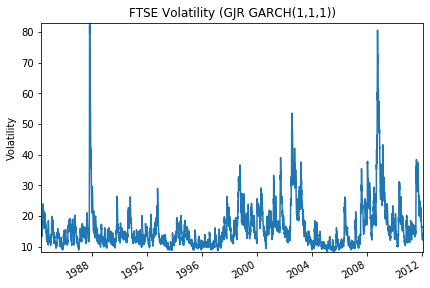

In [13]:
# Register date converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Produce a plot
dates = FTSE.index[1:]
fig = plt.figure()
ax = fig.add_subplot(111)
volatility = pd.DataFrame(np.sqrt(252 * sigma2), index=dates)
ax.plot(volatility.index,volatility)
ax.autoscale(tight='x')
fig.autofmt_xdate()
fig.tight_layout(pad=1.5)
ax.set_ylabel('Volatility')
ax.set_title('FTSE Volatility (GJR GARCH(1,1,1))')
plt.show()